In [1]:
import numpy as np
import scipy as sp

from scipy.stats import norm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.linalg import expm
from scipy.stats import norm

from timeit import default_timer as timer
import pickle

import nmresearch as nmr

In [2]:
# lattice vectors for fluorapatite crystal lattice (hexagonal)
# All units are in angstroms

a = 9.224*np.array([1, 0 , 0])
b = 9.224*np.array([np.cos(120*np.pi/180), np.sin(120*np.pi/180), 0])
c = 6.805*np.array([0,0,1])

In [3]:
# these are in the crystal coordinate axes, so [x,y,z] == x*a + y*b + z*c
def to_real_space(vec):
    return a*vec[0] + b*vec[1] + c*vec[2]


# 2 fluorine sites in a unit cell
f_cell = np.array([ [0,0,1/4], [0,0,3/4] ])

f_space = np.array([to_real_space(atom) for atom in f_cell])

# 6 phosphorus sites in a unit cell. These came from the literature
# citation needed LOL
d1 = .369
d2 = .3985

p_cell = np.array([[d1, d2, .25], [-d2, d1 - d2, .25], [d2 - d1, -d1, .25],
                   [-d1,-d2, .75], [d2, d2 - d1, .75], [d1-d2, d1, .75]])


def shift(cell, shift_vec):
    # cell is a unit cell of atoms (reduced coord)
    # shift_vec is a vector of integers
    # simple wrapper which takes a collection of reduced coordinate
    # vectors and returns the real space vectors, with an arbitrary shift
    # by a lattice vector
    #
    # Useful for tiling a unit cell and producing a larger crystal array
    
    return np.array([to_real_space(atom + shift_vec) for atom in cell])


f_space = np.concatenate(
            (
                shift(f_cell, [0,0,0]), shift(f_cell, [1,0,0]), shift(f_cell, [0,1,0]),
                shift(f_cell, [-1,0,0]), shift(f_cell, [0,-1,0]), shift(f_cell, [1,1,0]),
                shift(f_cell, [1,-1,0]), shift(f_cell, [-1,-1,0]), shift(f_cell, [-1,1,0])
            ),
    axis=0)


p_space = np.concatenate(
            (
                shift(p_cell, [0,0,0]), shift(p_cell, [1,0,0]), shift(p_cell, [0,1,0]),
                shift(p_cell, [-1,0,0]), shift(p_cell, [0,-1,0]), shift(p_cell, [1,1,0]),
                shift(p_cell, [1,-1,0]), shift(p_cell, [-1,-1,0]), shift(p_cell, [-1,1,0])
            ),
    axis=0)

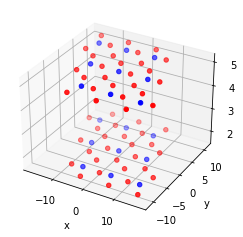

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(f_space.transpose()[0],f_space.transpose()[1],f_space.transpose()[2], c='b', marker='o')
ax.scatter(p_space.transpose()[0],p_space.transpose()[1],p_space.transpose()[2], c='r', marker='o')
plt.xlabel("x")
plt.ylabel("y")

plt.show()

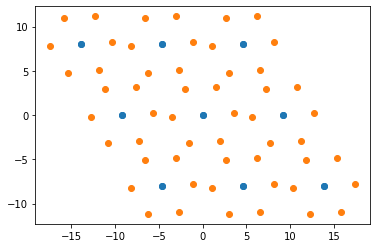

In [5]:
# sanity check, xy axis projection
plt.scatter(f_space.transpose()[0],f_space.transpose()[1])
plt.scatter(p_space.transpose()[0],p_space.transpose()[1])
plt.show()

In [6]:
p_space_3d =  np.concatenate(
            (
                shift(p_cell, [0,0,0]), shift(p_cell, [1,0,0]), shift(p_cell, [0,1,0]),
                shift(p_cell, [-1,0,0]), shift(p_cell, [0,-1,0]), shift(p_cell, [1,1,0]),
                shift(p_cell, [1,-1,0]), shift(p_cell, [-1,-1,0]), shift(p_cell, [-1,1,0]),
                
                shift(p_cell, [0,0,1]), shift(p_cell, [1,0,1]), shift(p_cell, [0,1,1]),
                shift(p_cell, [-1,0,1]), shift(p_cell, [0,-1,1]), shift(p_cell, [1,1,1]),
                shift(p_cell, [1,-1,1]), shift(p_cell, [-1,-1,1]), shift(p_cell, [-1,1,1]),
                
                shift(p_cell, [0,0,-1]), shift(p_cell, [1,0,-1]), shift(p_cell, [0,1,-1]),
                shift(p_cell, [-1,0,-1]), shift(p_cell, [0,-1,-1]), shift(p_cell, [1,1,-1]),
                shift(p_cell, [1,-1,-1]), shift(p_cell, [-1,-1,-1]), shift(p_cell, [-1,1,-1])
            ),
    axis=0)

origin = .25*c
num_phos = len(p_space_3d)


In [38]:
gammaF = 251.662*10**6 # rad/s/T
gammaP = 108.291*10**6
B = 7.1 # T
hbar = 1.05457*10**(-34) # J s / rad

dxF = .5*6.878*10**(-10) # m
dxP = np.linalg.norm(to_real_space(p_cell[0])-to_real_space(p_cell[1]))*10**-10 # m
dxFP = np.linalg.norm(to_real_space([0,0,.25])-to_real_space(p_cell[1]))*10**-10

mu0 = 4*np.pi*10**-7

omegaF = gammaF*B*10**-6/(2*np.pi)

In [39]:
JF = (10**-7) * hbar * gammaF * gammaF * (1-3*np.cos(0)**2) / (4.08*10**-10) **3

In [40]:
JF

-19668.000302972843

In [8]:
omegaF # MHz

284.3780841475872

In [9]:
JF = (10**-7) * hbar * gammaF * gammaF * (1-3*np.cos(0)**2) / dxF **3

In [10]:
JF  # rad/s

-32843.10192611753

In [11]:
JP = (10**-7) * hbar * gammaP * gammaP * (1-3*np.cos(np.pi/2)**2) / dxP**3

In [12]:
JP  # rad/s

533.0823970674701

In [13]:
JFP = (10**-7) * hbar * gammaF * gammaP * (1-3*np.cos(np.pi/2)**2) / dxFP**3

In [14]:
JFP # rad/s

6437.266713546437

In [15]:
def get_rand_config(n_spin,s=2):
    # get a random configuration of n_spins
    # each with spin-dimension s, so spin-1/2 is s=2,
    # spin-2 is s=5, etc (j=(s-1)/2)
    return rng.integers(low=0, high=s, size=n_spin)-(s-1)/2

def fp_coupling(f_loc, p_loc):
    # compute J_{ij}^{FP} for fluorine spin at `f_loc`, and
    # phosphorus spin at `p_loc`, both in units of angstroms
    # coupling returned in units of rad/s
    r = (p_loc-f_loc)*10**-10
    dx = np.linalg.norm(r)
    rhat = r/dx
    cos = rhat[2]
    return (10**-7) * hbar * gammaF * gammaP * (1-3*cos**2) / dx**3
    

def mean_field_calc(origin, crystal, config):
    # calculate mean field at `origin` given spin locations defined
    # in `crystal`, each with orientation defined by `config`
    gammaF = 251.662*10**6 # rad/s/T
    gammaP = 108.291*10**6
    hbar = 1.05457*10**(-34) # J s / rad
    return sum([fp_coupling(origin, spin)*orien for spin, orien in zip(crystal, config)])

rng = np.random.default_rng(8008502139)

In [16]:
get_rand

NameError: name 'get_rand' is not defined

In [17]:
mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))

-2133.5455429185

In [18]:
try:
    FaP_distro = pickle.load(open("FaP_distro_1e6.dat", "rb"))
except (OSError, IOError) as e:
    start = timer()
    trials = 1000000
    FaP_distro = np.zeros(trials)
    for idx in range(trials):
        FaP_distro[idx] = mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))
    end = timer()
    print("computation time " + str(end-start))
    with open('FaP_distro_1e6.dat', 'wb') as fi:
        pickle.dump(FaP_distro, fi)


In [19]:
start = timer()
trials = 10000
FaP_distro = np.zeros(trials)
for idx in range(trials):
    FaP_distro[idx] = mean_field_calc(to_real_space([0,0,.25]), p_space_3d, get_rand_config(num_phos))
end = timer()
print("computation time " + str(end-start))

computation time 12.072647799999999


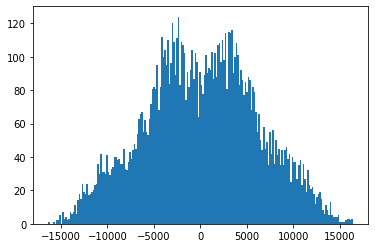

In [20]:
plt.hist(FaP_distro,bins=200,density=False)

plt.show()

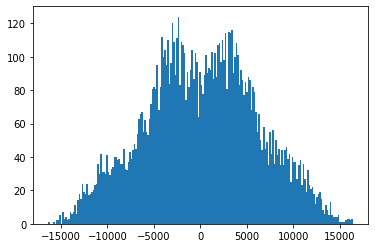

In [21]:
plt.hist(FaP_distro,bins=200,density=False)

plt.show()

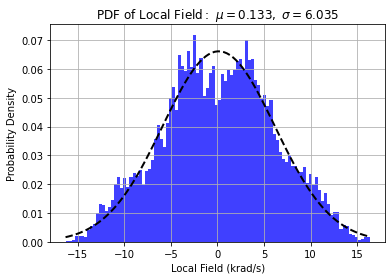

In [22]:
# best fit of data
(mu, sigma) = norm.fit(FaP_distro/1000)

# the histogram of the data
n, bins, patches = plt.hist(FaP_distro/1000, 100, density=True, facecolor='blue', alpha=0.75)

# add a 'best fit' line
y = norm.pdf( bins, mu, sigma)
l = plt.plot(bins, y, 'k--', linewidth=2)

#plot
plt.xlabel('Local Field (krad/s)')
plt.ylabel('Probability Density')
plt.title(r'$\mathrm{PDF\ of\ Local\ Field:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)

plt.show()

In [23]:
import numpy as np
from sklearn import mixture


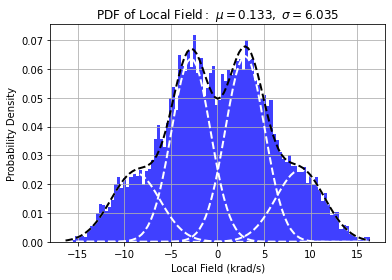

In [24]:
x = np.array(FaP_distro/1000).reshape(-1,1)

clf = mixture.GaussianMixture(n_components=4, covariance_type='full')
clf.fit(x)

# the histogram of the data
n, bins, patches = plt.hist(FaP_distro/1000, 100, density=True, facecolor='blue', alpha=0.75)

#plot
plt.xlabel('Local Field (krad/s)')
plt.ylabel('Probability Density')
plt.title(r'$\mathrm{PDF\ of\ Local\ Field:}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))
plt.grid(True)


y0 = norm.pdf(bins,clf.means_[0,0], clf.covariances_[0,0,0]**.5)
plt.plot(bins, y0*clf.weights_[0], 'w--', linewidth=2)

y1 = norm.pdf(bins,clf.means_[1,0], clf.covariances_[1,0,0]**.5)
plt.plot(bins, y1*clf.weights_[1], 'w--', linewidth=2)

y2 = norm.pdf(bins,clf.means_[2,0], clf.covariances_[2,0,0]**.5)
plt.plot(bins, y2*clf.weights_[2], 'w--', linewidth=2)

y3 = norm.pdf(bins,clf.means_[3,0], clf.covariances_[3,0,0]**.5)
plt.plot(bins, y3*clf.weights_[3], 'w--', linewidth=2)

y_sum = y1*clf.weights_[1]+y0*clf.weights_[0]+y2*clf.weights_[2]+y3*clf.weights_[3]

plt.plot(bins,y_sum,'k--', linewidth=2)


plt.show()

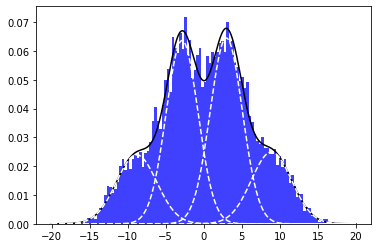

In [25]:
X = np.array(FaP_distro/1000).reshape(-1,1)
x = np.linspace(-20, 20, 1000)

logprob = clf.score_samples(x.reshape(-1, 1))
responsibilities = clf.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(FaP_distro/1000, 100, density=True, facecolor='blue', alpha=0.75)
plt.plot(x, pdf, '-k')
plt.plot(x, pdf_individual, '--w')
plt.show()

In [26]:
clf.get_params()

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 4,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [27]:
weight = clf.weights_
weight

array([0.33380832, 0.34195855, 0.1652053 , 0.15902784])

In [28]:
mu = clf.means_.transpose()[0]*2*np.pi*10**3
mu

array([-17848.6284715 ,  18634.79400882,  55916.8313406 , -55431.19492475])

In [29]:
sigma = (clf.covariances_.transpose()[0,0]**.5)*2*np.pi*10**3
sigma

array([13153.98654028, 13297.23680707, 16630.35158813, 16661.98123293])

In [30]:
t = np.arange(0,1000,1)*10**-6

sig = .5+.5*sum([w*np.exp(-(sig*t/3)**2)*np.cos(np.sqrt(2)*mean*t/3) for mean,sig,w in zip(mu,sigma,weight)])

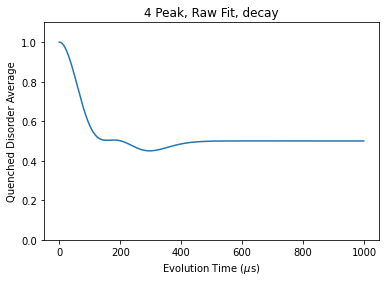

In [31]:
plt.plot(t*10**6,sig)
plt.ylim([0,1.1])
plt.xlabel(r"Evolution Time ($\mu$s)")
plt.ylabel("Quenched Disorder Average")
plt.title("4 Peak, Raw Fit, decay")
plt.show()

In [32]:
mu_sym = np.array([-9,-3,3,9])*2*np.pi*10**3
sigma_sym = np.array([2.1,2.7,2.7,2.1])*2*np.pi*10**3
weight_sym = np.array([1/6,1/3,1/3,1/6])

In [33]:
sig_sym = .5+.5*sum([w*np.exp(-(sig*t/3)**2)*np.cos(np.sqrt(2)*mean*t/3) for mean,sig,w in zip(mu_sym,sigma_sym,weight_sym)])

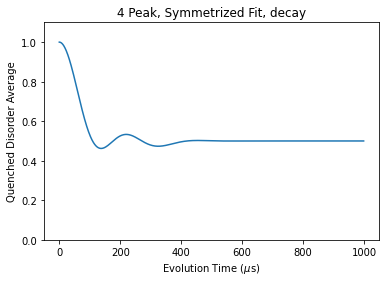

In [34]:
plt.plot(t*10**6,sig_sym)
plt.ylim([0,1.1])
plt.xlabel(r"Evolution Time ($\mu$s)")
plt.ylabel("Quenched Disorder Average")
plt.title("4 Peak, Symmetrized Fit, decay")
plt.show()

In [35]:
d1 = 0.36853
d2 = 0.39785
fl = nmr.Atom(dim_s=2, gamma=251.662 * 10**6, name="flourine")
ph = nmr.Atom(dim_s=2, gamma=108.291 * 10**6, name="phosphorous")

unit_cell = {
    fl: np.array([[0, 0, 1 / 4], [0, 0, 3 / 4]]),
    ph: np.array(
        [
            [d1, d2, 0.25],
            [-d2, d1 - d2, 0.25],
            [d2 - d1, -d1, 0.25],
            [-d1, -d2, 0.75],
            [d2, d2 - d1, 0.75],
            [d1 - d2, d1, 0.75],
        ]
    ),
}


In [36]:
fp_lat = np.array(
    [
        [9.375, 9.375 * np.cos(120 * np.pi / 180), 0],
        [0, 9.375 * np.sin(120 * np.pi / 180), 0],
        [0, 0, 6.887],
    ]
)
fp_xtal = nmr.Crystal(unit_cell, fp_lat)

In [37]:
fp_xtal.to_real_space([0,1,0])

array([-4.6875    ,  8.11898816,  0.        ])